Installing pre-requisites

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 89.4MB 31kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The notebook is divided into 3 parts:
- In the first part we import the images and create the dataframe
- In the second part we define our embedding network and train it on the given images
- In the last part we use the embedding network to create a classifier and use it to classify the given images

## Part 1: Data import and dataframe creation

Importing important libraries for the section

In [4]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Just like the previous section, we will repeat the same steps for dataset creation
Replace the path below with the path to the folder containing the 0-9 folders from Task 1

In [5]:
pathToDataset = '/content/drive/MyDrive/MIDAS/TASK 2/train'

In [6]:
imagePath = []
labels = []
for folder in os.listdir(pathToDataset):
    for images in os.listdir(os.path.join(pathToDataset,folder)):
        image = os.path.join(pathToDataset,folder,images)
        imagePath.append(image)
        labels.append(folder)
data = {'Images':imagePath, 'Labels':labels}
data = pd.DataFrame(data)
data.head()

,Images,Labels
0,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001
1,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001
2,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001
3,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001
4,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001


In [7]:
labelEncoder = LabelEncoder()
data['Encoded Labels'] = labelEncoder.fit_transform(data['Labels'])
data.head()

,Images,Labels,Encoded Labels
0,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001,0
1,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001,0
2,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001,0
3,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001,0
4,/content/drive/MyDrive/MIDAS/TASK 2/train/Samp...,Sample001,0


In [8]:
batchSize = 128
validationSplit = 0.15
shuffleDataset = True
randomSeed = 17

In [9]:
datasetSize = len(data)
indices = list(range(datasetSize))
split = int(np.floor(validationSplit*datasetSize))
if shuffleDataset:
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
trainIndices, validationIndices = indices[split:], indices[:split]

In [10]:
trainSampler = SubsetRandomSampler(trainIndices)
validationSampler = SubsetRandomSampler(validationIndices)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, imageData, imagePath, transform=None):
        self.imagePath = imagePath
        self.imageData = imageData
        self.transform = transform
    def __len__(self):
        return len(self.imageData)
    def __getitem__(self, index):
        imageName = os.path.join(self.imagePath, self.imageData.loc[index, 'Labels'],self.imageData.loc[index,'Images'])
        image = Image.open(imageName).convert('L')
        image = image.resize((32,32))
        label = torch.tensor(self.imageData.loc[index, 'Encoded Labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image,label

In [12]:
transform = transforms.Compose(
    [transforms.Resize(220),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

In [13]:
dataset = CustomDataset(data,pathToDataset,transform)

In [14]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = trainSampler)
validationLoader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, sampler = validationSampler)

In [15]:
def  displayImage(image):
    image = image/2 + 0.5
    image = image.numpy()
    image = image.reshape(220,220)
    return image

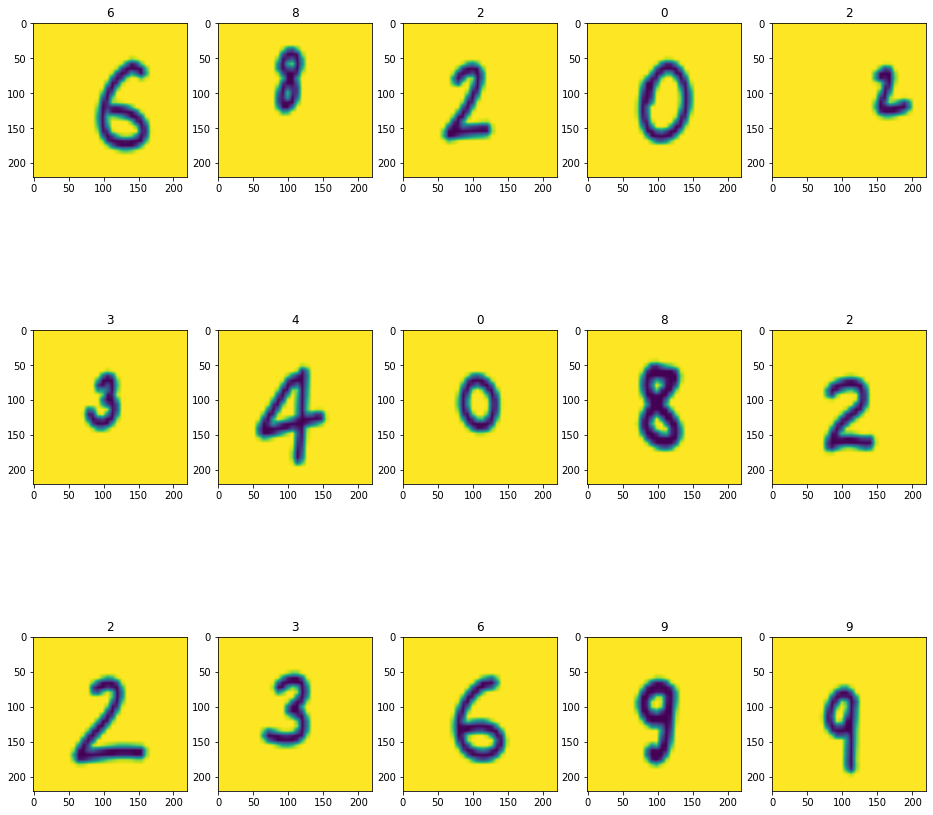

In [16]:
dataIterator = iter(trainLoader)
images, labels = dataIterator.next()
figure, axis = plt.subplots(3,5, figsize=(16,16))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image))
        ax.set(title=f"{label.item()}")

## Part 2: Classification (Pre-training before MNIST)

In this part we first pre-train our model on the provided dataset and then fine-tune it on the MNIST dataset. 

In [17]:
#the pytorch metric learning library comes with inbuilt methods for triplet mining and computing triplet losses between anchor, positive class and negative class
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training the model on: ",device, " Available GPU: ", torch.cuda.get_device_name(0))

Training the model on:  cuda:0  Available GPU:  Tesla T4


This time we shall be using a much simpler neural network as opposed to the previous task, as the features to be extracted for Numerical pictures are much less.

In [20]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (7,7), stride=(2,2), padding=(3,3)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3, 3), 2, padding=(1,1))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,(1,1), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.001),
            nn.Conv2d(64,192, (3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192,192,(1,1), stride=(1,1)),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.001),
            nn.Conv2d(192,384,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3), 2, padding=(1,1))
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,(1,1), stride=(1,1)),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.001),
            nn.Conv2d(384,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256,256,(1,1), stride=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.Conv2d(256,256,(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d((3,3),2, padding=(1,1)),
            nn.Flatten()
        )
        self.fullyConnected = nn.Sequential(
            nn.Linear(7*7*256,32*128),
            nn.BatchNorm1d(32*128),
            nn.LeakyReLU(0.001),
            nn.Linear(32*128,128)
        )
    def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.fullyConnected(x)
      return torch.nn.functional.normalize(x, p=2, dim=-1)

In [21]:
embeddingNetwork = EmbeddingNetwork().to(device)
print(embeddingNetwork)

EmbeddingNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.001)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.001)
    (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affin

Trainer function similar to SUB TASK 1

In [22]:
def train(model, lossFunction, miningFunction, device, trainLoader, optimizer, epoch):
    print("Training started for Epoch: ",epoch)
    model.train()
    for batchIndex, (data, labels) in enumerate(trainLoader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        hardPairs = miningFunction(embeddings, labels)
        loss = lossFunction(embeddings, labels, hardPairs)
        loss.backward()
        optimizer.step()
        if batchIndex%3==0:
            print("Training Stats for Epoch {} Iteration {}: Loss= {}, Number of mined triplets {}".format(epoch, batchIndex, loss, miningFunction.num_triplets))

Defining loss function and other parameters

In [23]:
#distance this tells the model how to calculate the distance between the  generated embeddings
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0.0)
lossFunction = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
miningFunction = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semi-hard")
optimizer = torch.optim.Adam(embeddingNetwork.parameters(), lr=0.05)

Standard test function using a KNN Classifier to test the embedding model

In [24]:
def tester(maxValidationAccuracy):
  trainEmbeddings = []
  trainLabels = []
  validationEmbeddings = []
  validationLabels = []
  with torch.no_grad():
    embeddingNetwork.eval()
    for (dataTr, labelTr) in (trainLoader):
      dataTr, labelTr = dataTr.to(device), labelTr.to(device)
      embeddingTr = embeddingNetwork(dataTr)
      trainEmbeddings.append(embeddingTr.cpu().detach().numpy())
      trainLabels.append(labelTr.cpu().detach().numpy())
    for (dataTe, labelTe) in (validationLoader):
      dataTe, labelTe = dataTe.to(device), labelTe.to(device)
      embeddingsTe = embeddingNetwork(dataTe)
      validationEmbeddings.append(embeddingsTe.cpu().detach().numpy())
      validationLabels.append(labelTe.cpu().detach().numpy())
  trainEmbeddings1 = []
  trainLabels1 = []
  validationEmbeddings1 = []
  validationLabels1 = []
  for bat in trainEmbeddings:
    for exm in bat:
      trainEmbeddings1.append(exm)
  for bat in trainLabels:
    for exm in bat:
      trainLabels1.append(exm)
  for bat in validationEmbeddings:
    for exm in bat:
      validationEmbeddings1.append(exm)
  for bat in validationLabels:
    for exm in bat:
      validationLabels1.append(exm)
  neigh = KNeighborsClassifier(n_neighbors=13)
  neigh.fit(trainEmbeddings1, trainLabels1)
  prediction = neigh.predict(validationEmbeddings1)
  currentAccuracy = accuracy_score(validationLabels1,prediction)
  print("Accuracy: ",currentAccuracy)
  if currentAccuracy > maxValidationAccuracy:
    maxValidationAccuracy = currentAccuracy
    print("New highest validation accuracy, saving the embedding model")
    torch.save(embeddingNetwork.state_dict(), "embeddingNetworkTask2.pt")
  return maxValidationAccuracy

Now that our training and testing functions are ready, we shall pre-train our model on the given dataset. We also save the model having highest validation accuracy, these saved weights will be used to fine-tune the MNIST dataset and make further inferences. This is done below:

In [25]:
maxValidationAccuracy = 0
for epoch in range(1, 81):
    train(embeddingNetwork, lossFunction, miningFunction, device, trainLoader, optimizer, epoch)
    print("Training completed for the Epoch:", epoch)
    maxValidationAccuracy = tester(maxValidationAccuracy)

Training started for Epoch:  1
Training Stats for Epoch 1 Iteration 0: Loss= 0.18509072065353394, Number of mined triplets 162532
Training completed for the Epoch: 1
Accuracy:  0.35
New highest validation accuracy, saving the embedding model
Training started for Epoch:  2
Training Stats for Epoch 2 Iteration 0: Loss= 0.19447579979896545, Number of mined triplets 122693
Training completed for the Epoch: 2
Accuracy:  0.43333333333333335
New highest validation accuracy, saving the embedding model
Training started for Epoch:  3
Training Stats for Epoch 3 Iteration 0: Loss= 0.19929517805576324, Number of mined triplets 94758
Training completed for the Epoch: 3
Accuracy:  0.38333333333333336
Training started for Epoch:  4
Training Stats for Epoch 4 Iteration 0: Loss= 0.18976910412311554, Number of mined triplets 83885
Training completed for the Epoch: 4
Accuracy:  0.38333333333333336
Training started for Epoch:  5
Training Stats for Epoch 5 Iteration 0: Loss= 0.1759995073080063, Number of mi

In [26]:
print("Highest Validation Accuracy acheived during training: ", maxValidationAccuracy)

Highest Validation Accuracy acheived during training:  0.9166666666666666


Loading the standard MNIST training and validation sets

In [27]:
from torchvision import datasets
mnistTrain = datasets.MNIST('.', train=True, download=True, transform=transform)
mnistTest = datasets.MNIST('.', train=False, transform=transform)
mnistTrainLoader = torch.utils.data.DataLoader(mnistTrain, batch_size=128, shuffle=True)
mnistTestLoader = torch.utils.data.DataLoader(mnistTest, batch_size=128)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Visualizing MNIST Train Images

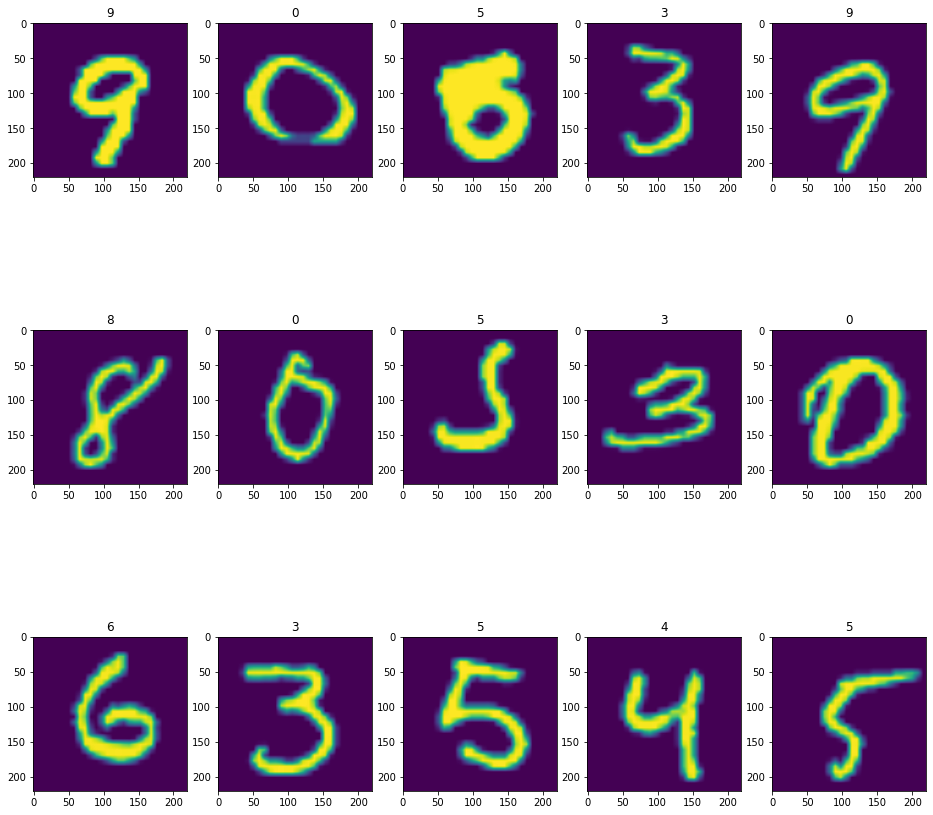

In [28]:
dataIterator = iter(mnistTrainLoader)
images, labels = dataIterator.next()
figure, axis = plt.subplots(3,5, figsize=(16,16))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image))
        ax.set(title=f"{label.item()}")

Now that our MNIST datasets are ready we shall fine-tune and test the model for MNIST dataset. Before we create the classifier, we shall fine tune the embedding network on the MNIST data too.

In [29]:
#loading best validated weights into the classifier
embeddingNetwork = EmbeddingNetwork().to(device)
embeddingNetwork.load_state_dict(torch.load('embeddingNetworkTask2.pt'))

<All keys matched successfully>

In [30]:
def trainMNIST(model, lossFunction, miningFunction, device, trainLoader, optimizer, epoch):
    print("Training started for Epoch: ",epoch)
    model.train()
    for batchIndex, (data, labels) in enumerate(trainLoader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        hardPairs = miningFunction(embeddings, labels)
        loss = lossFunction(embeddings, labels, hardPairs)
        loss.backward()
        optimizer.step()
        if batchIndex%300==0:
            print("Training Stats for Epoch {} Iteration {}: Loss= {}, Number of mined triplets {}".format(epoch, batchIndex, loss, miningFunction.num_triplets))

In [31]:
#distance this tells the model how to calculate the distance between the  generated embeddings
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0.0)
lossFunction = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
miningFunction = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semi-hard")
optimizer = torch.optim.Adam(embeddingNetwork.parameters(), lr=0.05)

In [32]:
maxValidationAccuracyMNIST = 0.0
def testerMNIST(maxValidationAccuracyMNIST):
  trainEmbeddings = []
  trainLabels = []
  validationEmbeddings = []
  validationLabels = []
  with torch.no_grad():
    embeddingNetwork.eval()
    for (dataTr, labelTr) in (mnistTrainLoader):
      dataTr, labelTr = dataTr.to(device), labelTr.to(device)
      embeddingTr = embeddingNetwork(dataTr)
      trainEmbeddings.append(embeddingTr.cpu().detach().numpy())
      trainLabels.append(labelTr.cpu().detach().numpy())
    for (dataTe, labelTe) in (mnistTestLoader):
      dataTe, labelTe = dataTe.to(device), labelTe.to(device)
      embeddingsTe = embeddingNetwork(dataTe)
      validationEmbeddings.append(embeddingsTe.cpu().detach().numpy())
      validationLabels.append(labelTe.cpu().detach().numpy())
  trainEmbeddings1 = []
  trainLabels1 = []
  validationEmbeddings1 = []
  validationLabels1 = []
  for bat in trainEmbeddings:
    for exm in bat:
      trainEmbeddings1.append(exm)
  for bat in trainLabels:
    for exm in bat:
      trainLabels1.append(exm)
  for bat in validationEmbeddings:
    for exm in bat:
      validationEmbeddings1.append(exm)
  for bat in validationLabels:
    for exm in bat:
      validationLabels1.append(exm)
  neigh = KNeighborsClassifier(n_neighbors=13)
  neigh.fit(trainEmbeddings1, trainLabels1)
  prediction = neigh.predict(validationEmbeddings1)
  currentAccuracy = accuracy_score(validationLabels1,prediction)
  print("Accuracy: ",currentAccuracy)
  if currentAccuracy > maxValidationAccuracyMNIST:
    maxValidationAccuracyMNIST = currentAccuracy
    print("New highest validation accuracy, saving the embedding model")
    torch.save(embeddingNetwork.state_dict(), "embeddingNetworkMNIST.pt")
  return maxValidationAccuracyMNIST

In [33]:
maxValidationAccuracyMNIST = 0
for epoch in range(1, 5):
    trainMNIST(embeddingNetwork, lossFunction, miningFunction, device, mnistTrainLoader, optimizer, epoch)
    print("Training completed for the Epoch:", epoch)
    maxValidationAccuracyMNIST = testerMNIST(maxValidationAccuracyMNIST)

Training started for Epoch:  1
Training Stats for Epoch 1 Iteration 0: Loss= 0.4846818745136261, Number of mined triplets 80915
Training Stats for Epoch 1 Iteration 300: Loss= 0.16509121656417847, Number of mined triplets 2262
Training completed for the Epoch: 1
Accuracy:  0.9876
New highest validation accuracy, saving the embedding model
Training started for Epoch:  2
Training Stats for Epoch 2 Iteration 0: Loss= 0.14772742986679077, Number of mined triplets 1262
Training Stats for Epoch 2 Iteration 300: Loss= 0.18875926733016968, Number of mined triplets 1779
Training completed for the Epoch: 2
Accuracy:  0.9894
New highest validation accuracy, saving the embedding model
Training started for Epoch:  3
Training Stats for Epoch 3 Iteration 0: Loss= 0.22582054138183594, Number of mined triplets 1336
Training Stats for Epoch 3 Iteration 300: Loss= 0.08404570817947388, Number of mined triplets 216
Training completed for the Epoch: 3
Accuracy:  0.9903
New highest validation accuracy, savin

Classifying the MNIST Dataset using pre-trained model

In [34]:
class classifierNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(classifierNet, self).__init__()
        self.embeddingLayer = EmbeddingNet
        self.linearLayer = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.classifierLayer = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.embeddingLayer(x))
        x = self.dropout(self.linearLayer(x))
        x = self.classifierLayer(x)
        return F.log_softmax(x, dim=1)

In [35]:
bestEmbeddingNetwork = EmbeddingNetwork().to(device)
bestEmbeddingNetwork.load_state_dict(torch.load('embeddingNetworkMNIST.pt'))

<All keys matched successfully>

In [36]:
classifier = classifierNet(embeddingNetwork).to(device)
print(classifier)

classifierNet(
  (embeddingLayer): EmbeddingNetwork(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.001)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.001)
      (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(192, 192, kernel_size=(1, 1), st

In [ ]:
for param in classifier.embeddingLayer.parameters():
    param.requires_grad = False

Defining the NNL Loss function for classification as we are using log softmax layer in the end.

In [37]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
def accuracy(output, labels):
    _, predictions = torch.max(output, dim=1)
    return torch.sum(predictions==labels).item()

In [38]:
numberOfEpochs = 20
validAccuracyMaxTransfer = 0.0
validationLossTransfer = []
validationAccuracyTransfer = []
trainingLossTransfer = []
trainingAccuracyTransfer = []
totalSteps = len(mnistTrainLoader)
for epoch in range(1, numberOfEpochs):
    classifier.train()
    runningLoss = 0.0
    correct = 0
    total = 0
    print("Training started for Epoch: ",epoch)
    for batchIndex, (data, target) in enumerate(mnistTrainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
        if (batchIndex)%100 ==0:
            print("Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}".format(epoch,numberOfEpochs,batchIndex,totalSteps,loss.item()))
    trainingAccuracyTransfer.append(100*correct/total)
    trainingLossTransfer.append(runningLoss/totalSteps)
    print("Training Accuracy: ",(100*correct/total))
    batchLoss = 0
    totalV = 0
    correctV = 0
    with torch.no_grad():
        classifier.eval()
        for dataV, targetV in (mnistTestLoader):
            dataV, targetV = dataV.to(device), targetV.to(device)
            outputV = classifier(dataV)
            lossV = criterion(outputV,targetV)
            batchLoss += lossV.item()
            _, predV = torch.max(outputV, dim=1)
            correctV += torch.sum(predV==targetV).item()
            totalV += targetV.size(0)
        validationAccuracyTransfer.append(100*correctV/totalV)
        validationLossTransfer.append(batchLoss/len(mnistTestLoader))
        print("Validation Accuracy: ",(100*correctV/totalV))
        if (100*correctV/totalV)>validAccuracyMaxTransfer:
          validAccuracyMaxTransfer = 100*correctV/totalV
          print("Validation accuracy improved, network improvement detected, saving network")
          torch.save(classifier.state_dict(), "classifierNetworkTransferLearningTask2.pt")

    classifier.train()

Training started for Epoch:  1
Epoch [1/20] Step [0/469] Loss: 2.3174
Epoch [1/20] Step [100/469] Loss: 0.0121
Epoch [1/20] Step [200/469] Loss: 0.0037
Epoch [1/20] Step [300/469] Loss: 0.0177
Epoch [1/20] Step [400/469] Loss: 0.0613
Training Accuracy:  98.66333333333333
Validation Accuracy:  99.44
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  2
Epoch [2/20] Step [0/469] Loss: 0.1641
Epoch [2/20] Step [100/469] Loss: 0.0055
Epoch [2/20] Step [200/469] Loss: 0.0027
Epoch [2/20] Step [300/469] Loss: 0.0508
Epoch [2/20] Step [400/469] Loss: 0.0201
Training Accuracy:  99.48166666666667
Validation Accuracy:  99.5
Validation accuracy improved, network improvement detected, saving network
Training started for Epoch:  3
Epoch [3/20] Step [0/469] Loss: 0.0040
Epoch [3/20] Step [100/469] Loss: 0.0935
Epoch [3/20] Step [200/469] Loss: 0.0027
Epoch [3/20] Step [300/469] Loss: 0.0007
Epoch [3/20] Step [400/469] Loss: 0.0691
Training Accuracy

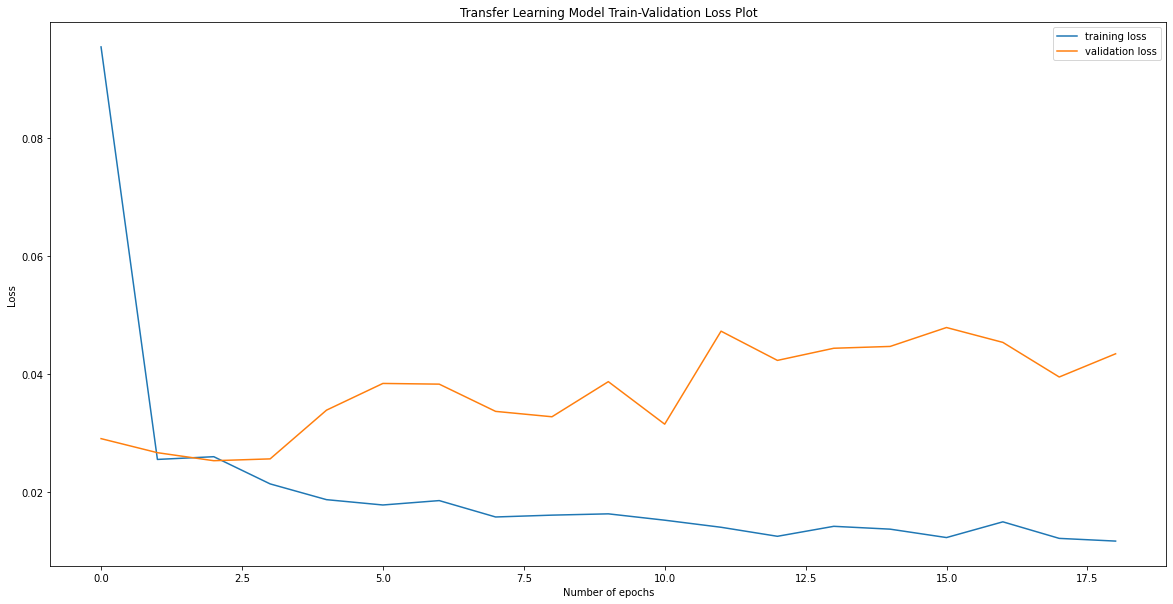

In [39]:
fig = plt.figure(figsize=(20,10))
plt.title("Transfer Learning Model Train-Validation Loss Plot")
plt.plot(trainingLossTransfer, label='training loss')
plt.plot(validationLossTransfer, label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

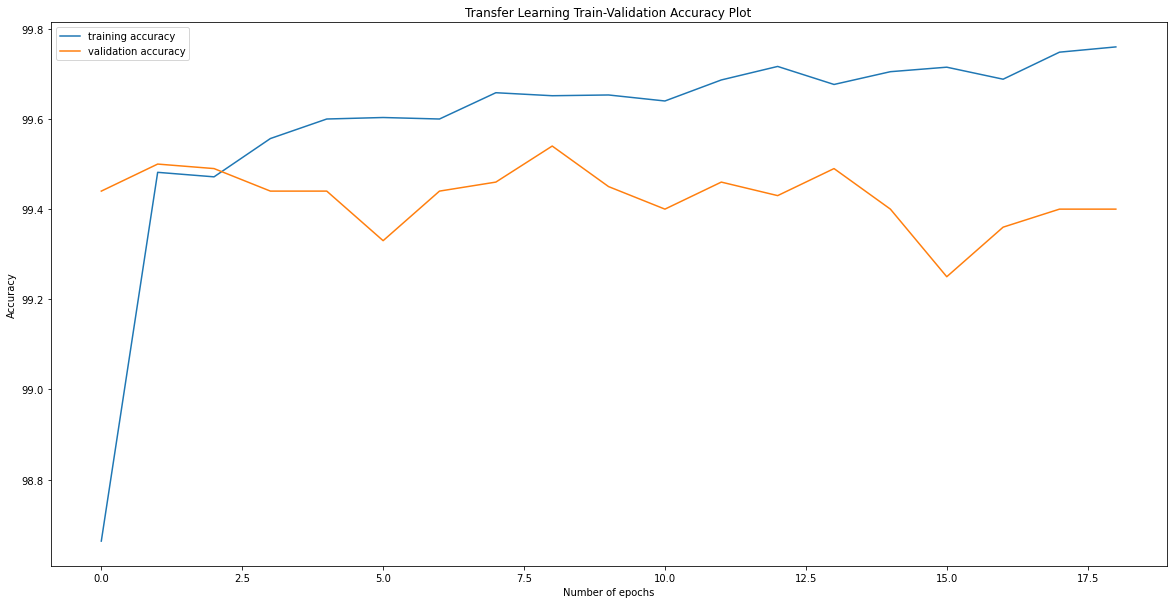

In [40]:
fig = plt.figure(figsize=(20,10))
plt.title("Transfer Learning Train-Validation Accuracy Plot")
plt.plot(trainingAccuracyTransfer, label='training accuracy')
plt.plot(validationAccuracyTransfer, label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')